In [1]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import new_interf

from datetime import datetime, timedelta



No module named 'rtlsdr'


In [2]:
moon_data = pd.read_csv('hour_data.csv')

moon_volts = np.array(moon_data['all_voltages'])
moon_times = np.array(moon_data['all_times'])
#print(datetime.utcfromtimestamp(moon_times[0]).strftime('%Y-%m-%d %H:%M:%S'), "in UTC")
def utc_to_local(unix_time):
    utc_dt = datetime.utcfromtimestamp(unix_time)
    time = utc_dt - timedelta(hours=8)
    tJ= ugradio.timing.julian_date(unix_time)
    return time.strftime('%Y-%m-%d %H:%M:%S'), tJ
t,tJ = utc_to_local(moon_times[0])
lst = ugradio.timing.lst(tJ)
print(t, "local time", tJ, "Julian time")

#print(moon_times[0], "time of observation in bullshit unix")
moon_times -= moon_times[0]  # this is shorthand for moontime = itself minus moontime[0]
dt = moon_times[1] - moon_times[0]  # this is the time step between samples
moon_volts-= moon_volts.mean()

2022-03-07 20:44:19 local time 2459646.6974421754 Julian time


<IPython.core.display.Javascript object>


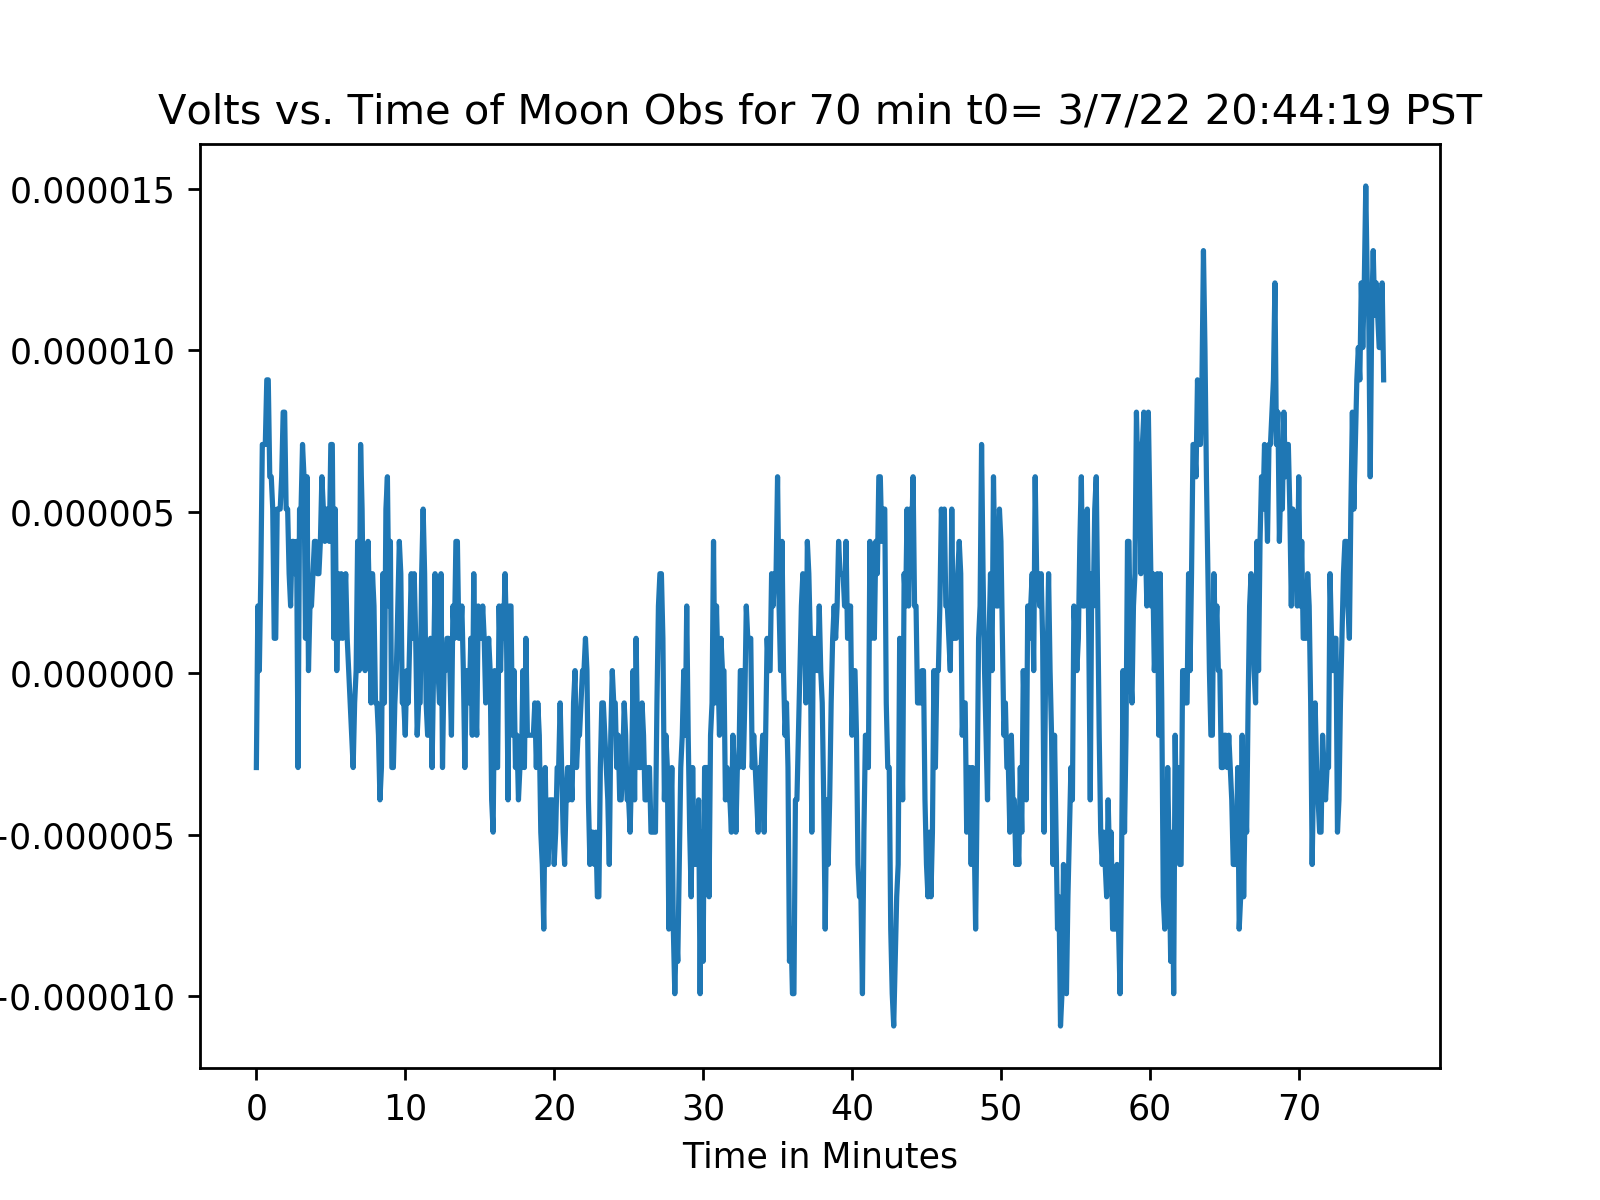

In [3]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Moon Obs for 70 min t0= 3/7/22 20:44:19 PST")
plt.plot(moon_times/60, moon_volts)
# we can see the frequencies are getting smaller 
# this happens at the horizons 
# frequency changes as the cosine of the angle (highest at zentih and lowest at horizon)

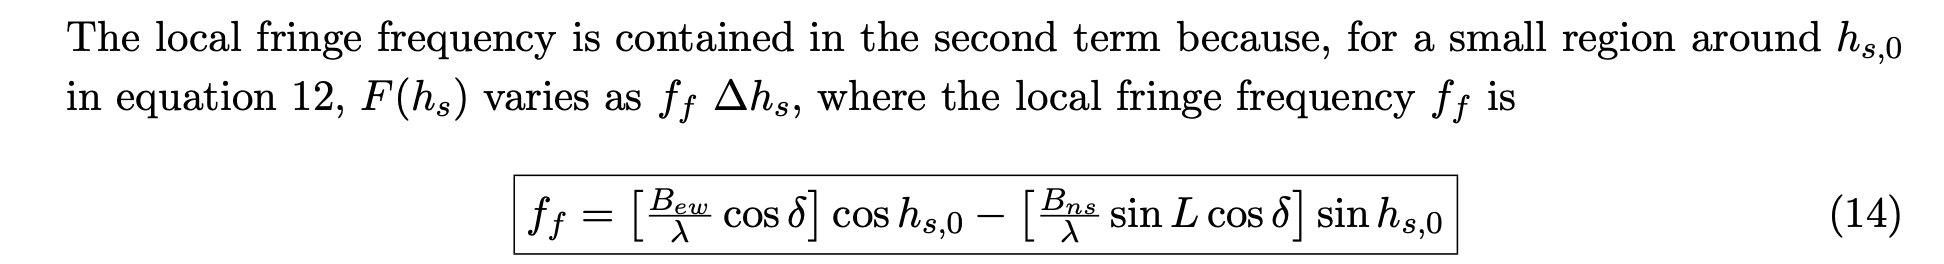

In [4]:
RA_deg, dec= ugradio.coord.moonpos(tJ) # wants julian date and it will return the RA and Dec
print(RA_deg, "RA in degrees")
#arc_dec= 10.6/60 #converting arc min to degrees 
#arc_dec
#dec = -16 - arc_dec
print(dec, "Dec in degrees")

precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
print("precess_ra is", precess_ra, "precess_dec is", precess_dec )
RA = np.radians(precess_ra)
Dec = np.radians(precess_dec)
print("RA is", RA, "Dec", Dec )

49.666575326123755 RA in degrees
17.854119872941258 Dec in degrees
precess_ra is 49.66233533984361 precess_dec is 17.853019912459597
RA is 0.866771265909808 Dec 0.3115939788965298


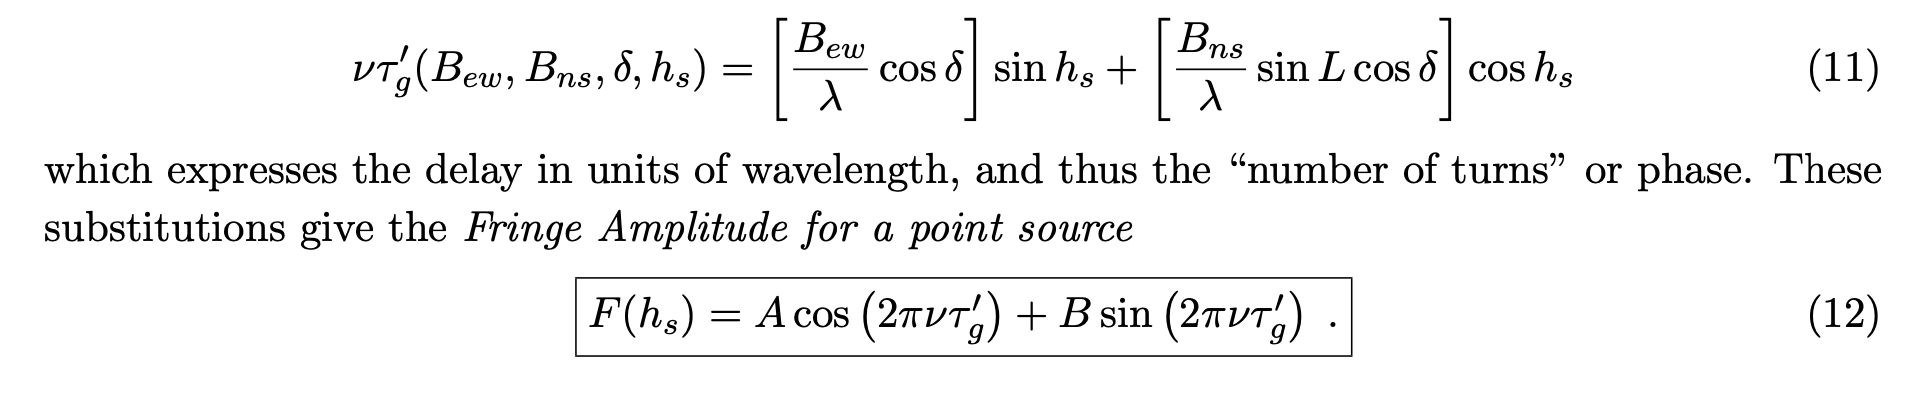

In [5]:
# guessing values for nu tau g to fit for the fringe amplitude

#guesses in meters
Bew = 20
Bns = 0
L = ugradio.nch.lat # latitude
wl = .0250  # wavelength in meters
# ntg = nu tao g
ntg = (Bew / wl *np.cos(Dec)) * np.sin(RA - lst) + (Bns / wl * np.sin(L)*np.cos(Dec))*np.cos(RA - lst)
print(ntg)

# now this needs to go into eq 12 (f is a function of A and B)


-690.3191367539492


<IPython.core.display.Javascript object>


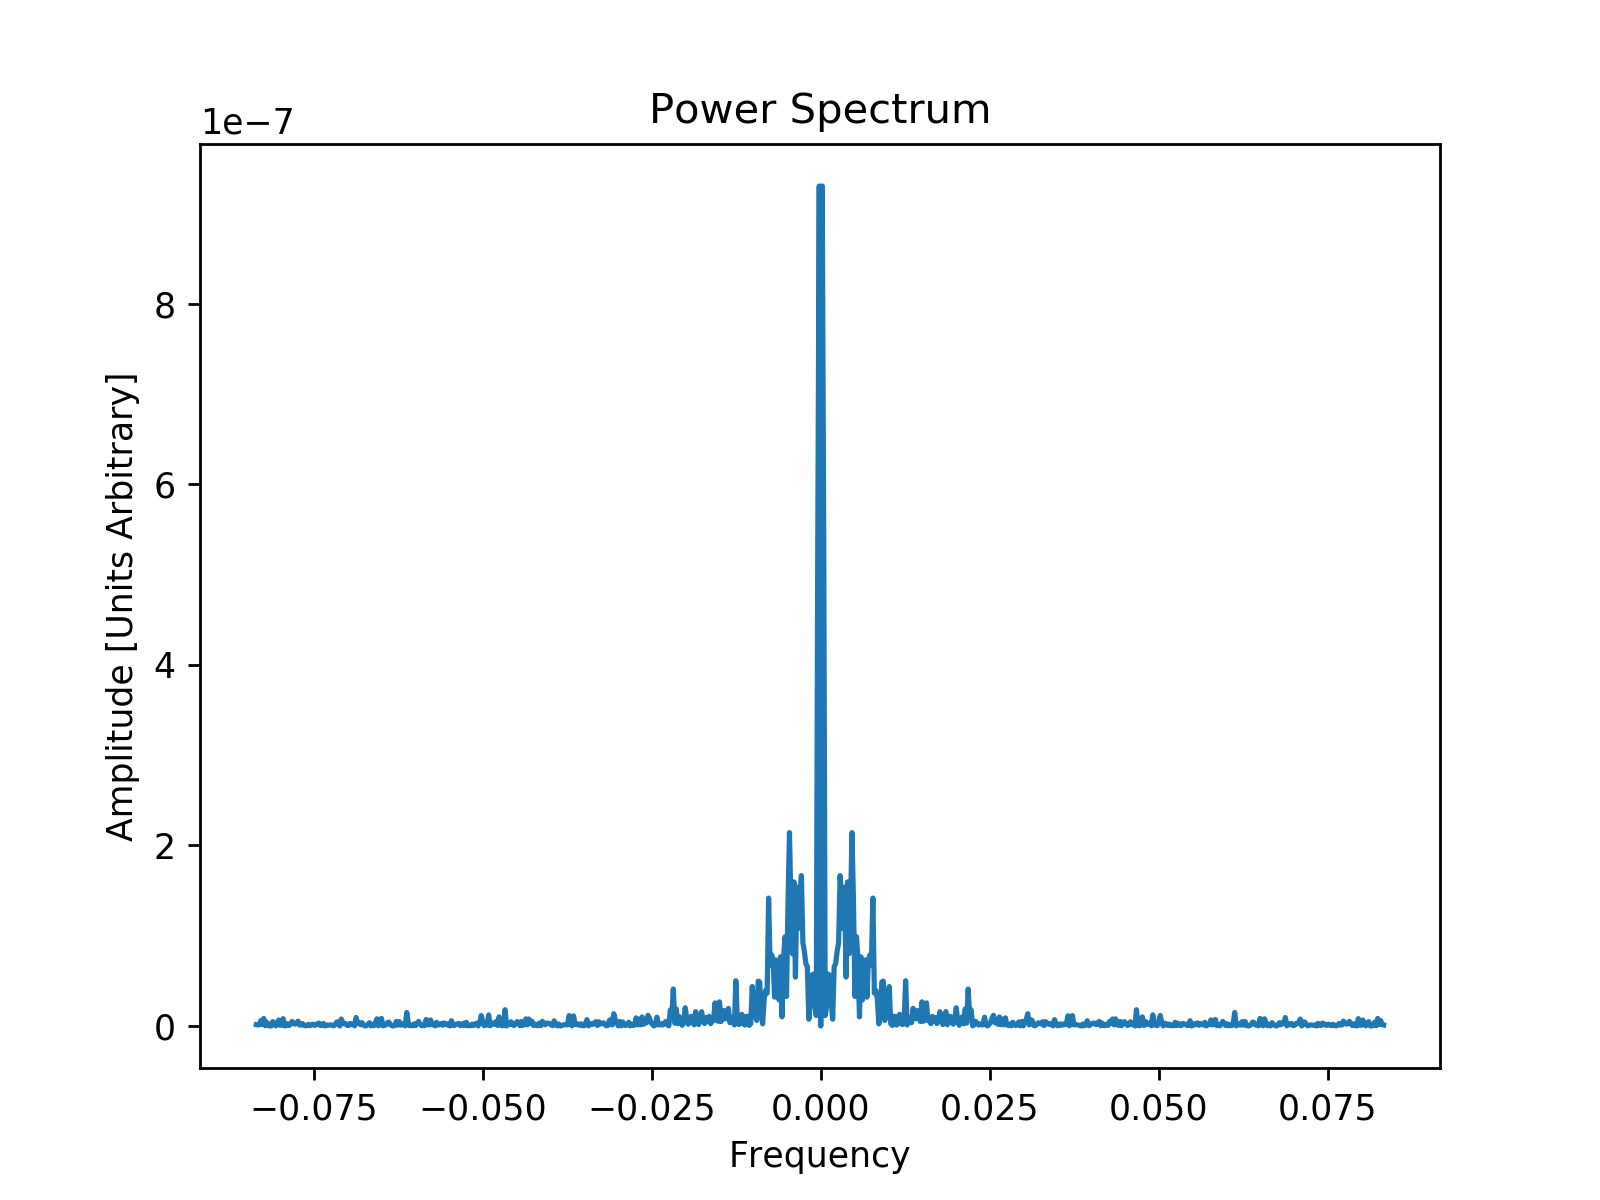

In [12]:
voltage_spectrum = np.fft.fft(moon_volts)
voltage_spectrum[0] = 0 # this is the same as subtracting the mean in the timeseries data 
power_spectrum = np.abs(voltage_spectrum)**2
frequencies = np.fft.fftfreq(len(power_spectrum), dt)

plt.figure()
plt.title("Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude [Units Arbitrary]")
plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(power_spectrum)) # shifting the arrays to read correctly

<IPython.core.display.Javascript object>


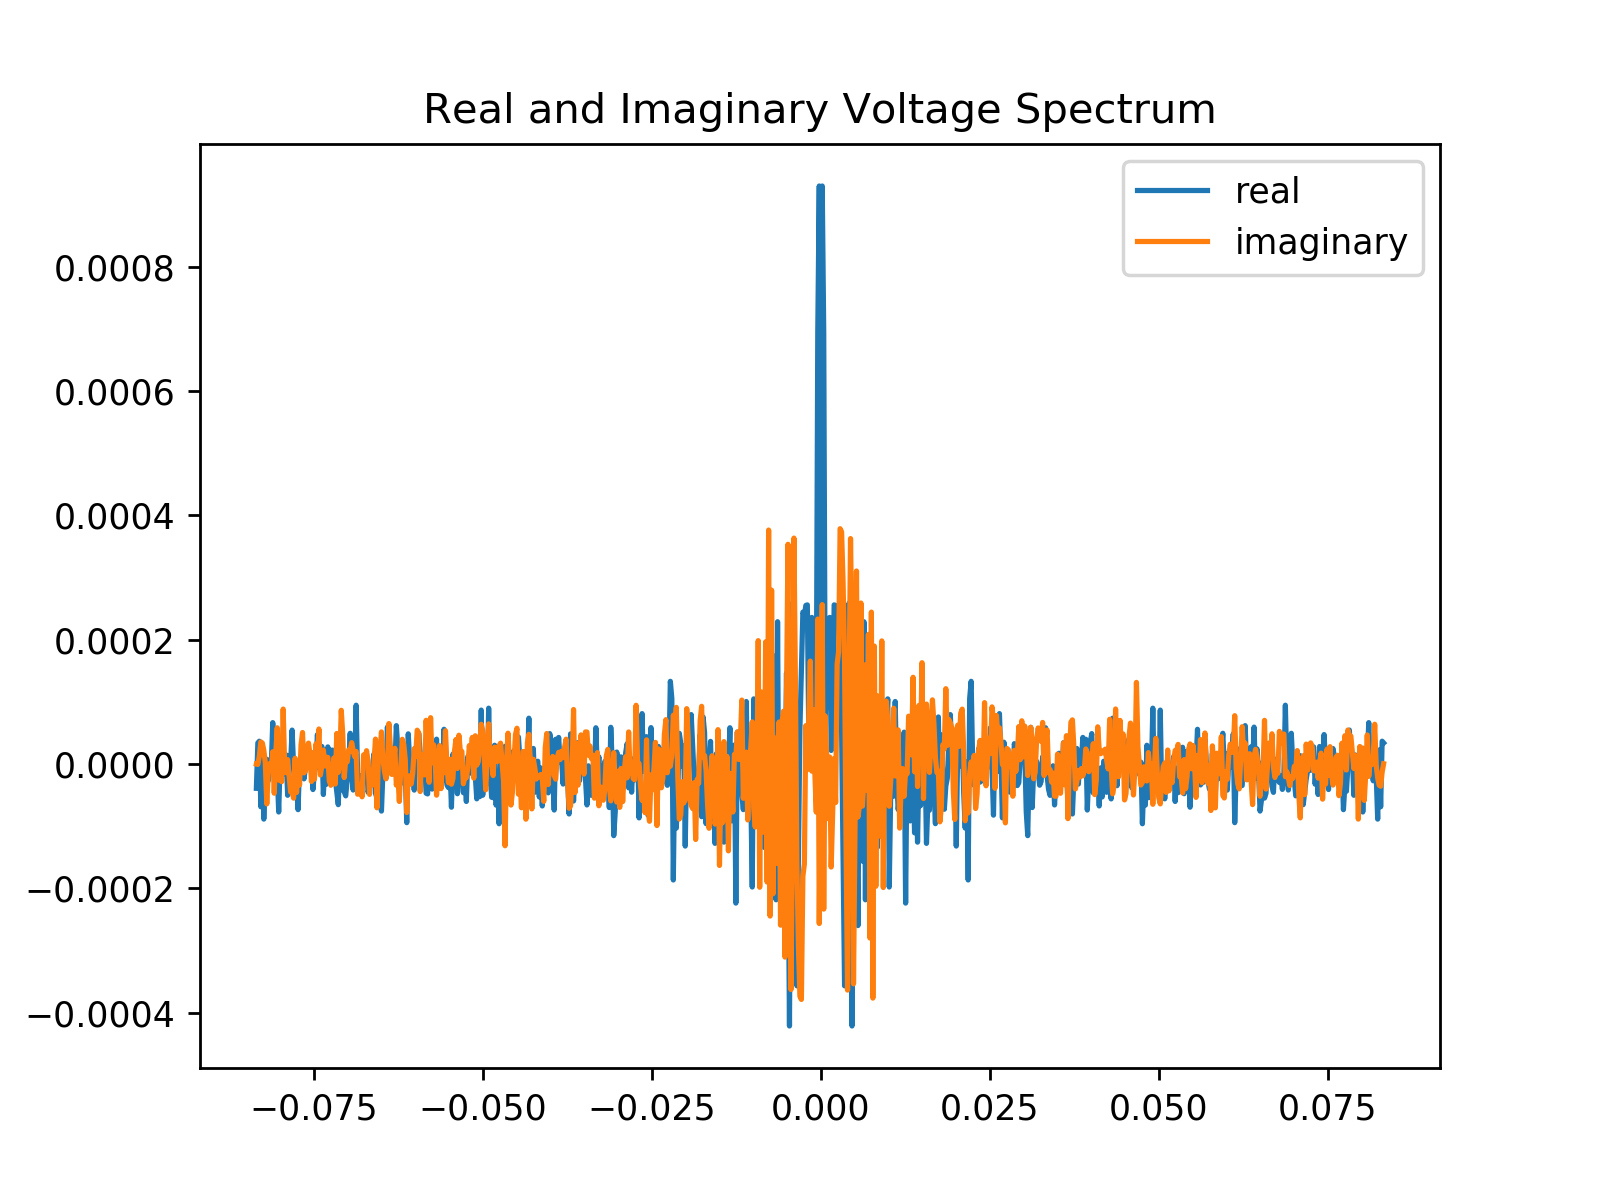

In [6]:
plt.figure()
plt.title("Real and Imaginary Voltage Spectrum")

plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(voltage_spectrum.real), label="real")
plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(voltage_spectrum.imag), label = "imaginary")# shifting the arrays to read correctly
plt.legend()

In [7]:
moon_spectra = new_interf.f_transform(moon_volts)
new_interf.f_transform??

<IPython.core.display.Javascript object>


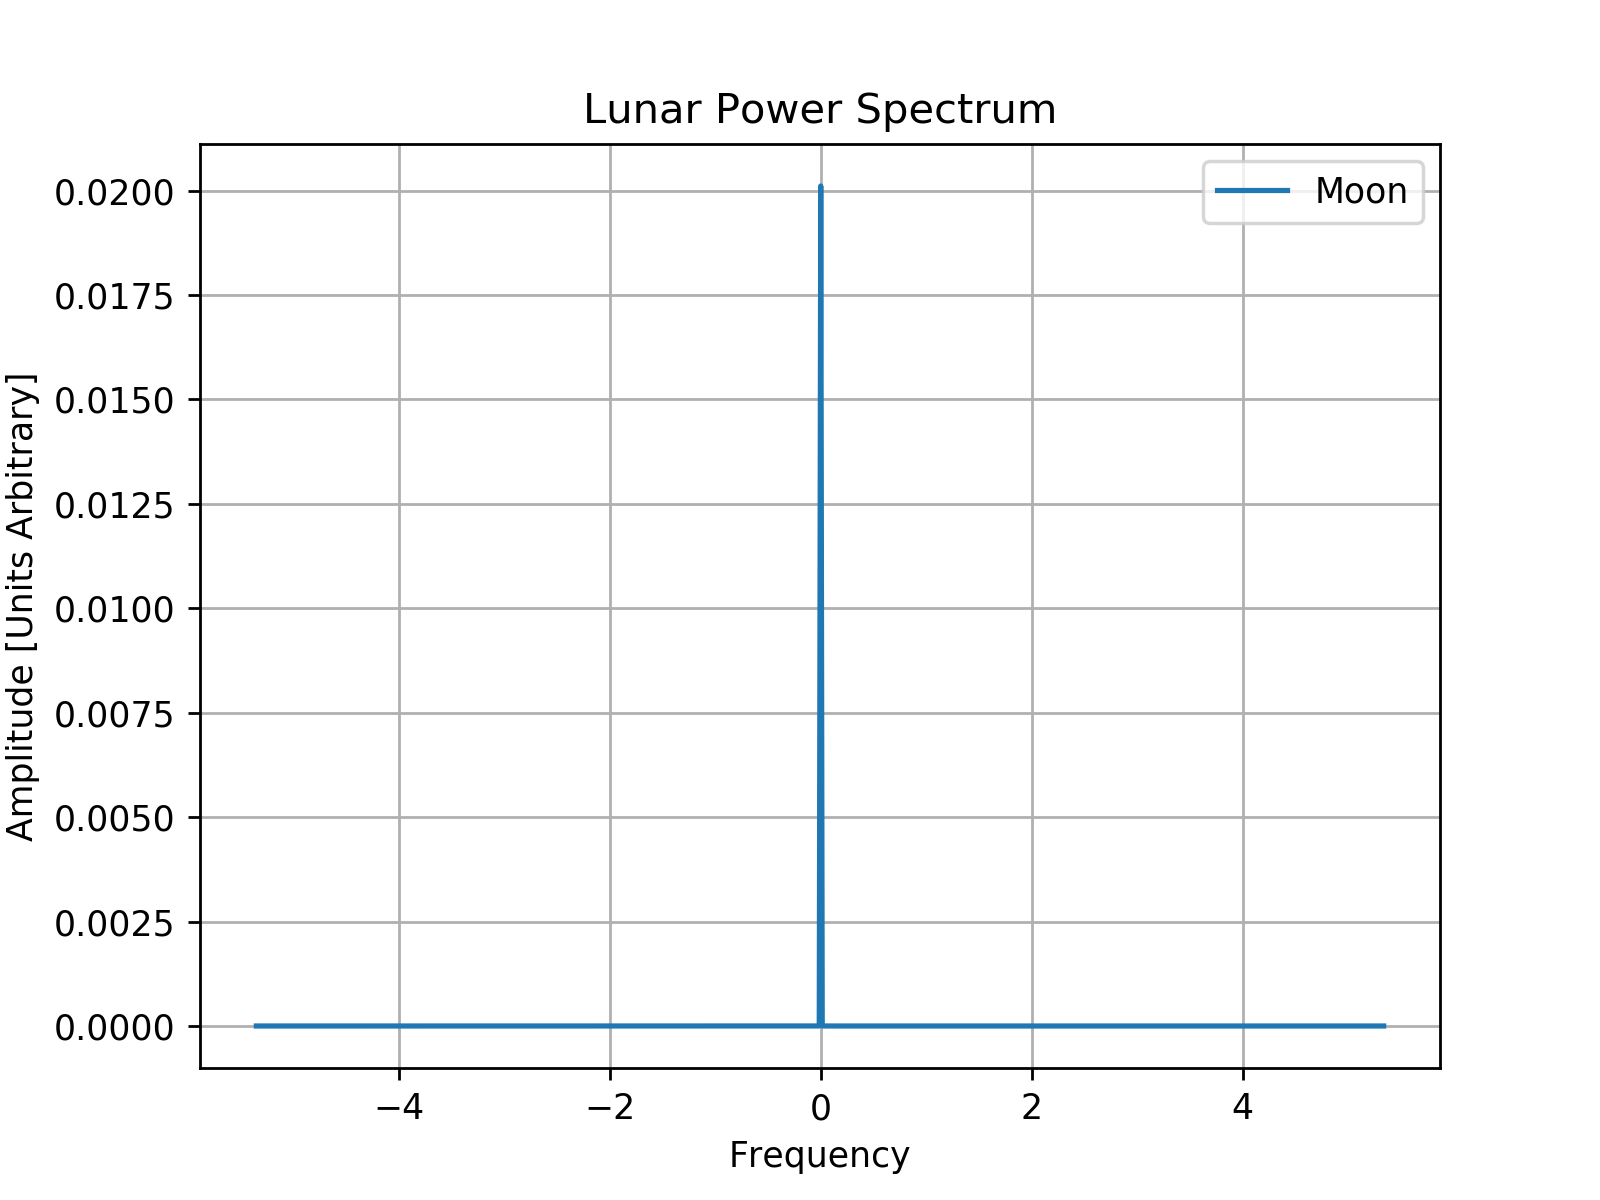

In [8]:
plt.figure()
plt.grid()
plt.title('Lunar Power Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude [Units Arbitrary]')
plt.plot(moon_spectra[0], moon_spectra[1], label = "Moon")
plt.legend()
plt.show()